# ATP6V0C
[early-onset epilepsy-3 with or without developmental delay (EPEO3)](https://omim.org/entry/620465) is caused by heterozygous mutation in the ATP6V0C gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


### ATP6V0C
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ATP6V0C.

In [2]:
gene_symbol = 'ATP6V0C'
mane_tx_id = 'NM_001694.4'
mane_protein_id = 'NP_001685.1' # V-type proton ATPase 16 kDa proteolipid subunit c [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.21') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
"""
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
"""
ppf = "../../../phenopacket-store/notebooks/ATP6V0C/phenopackets"
cohort, qc_results = load_phenopacket_folder(ppf, cohort_creator)
qc_results.summarize()

Individuals Processed: 31individuals [00:00, 105.33individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,21
Bilateral tonic-clonic seizure,HP:0002069,18
EEG abnormality,HP:0002353,15
Febrile seizure (within the age range of 3 months to 6 years),HP:0002373,12
Delayed speech and language development,HP:0000750,12
Motor delay,HP:0001270,11
Autistic behavior,HP:0000729,10
Myoclonic seizure,HP:0032794,8
Atonic seizure,HP:0010819,7
Hypotonia,HP:0001252,6


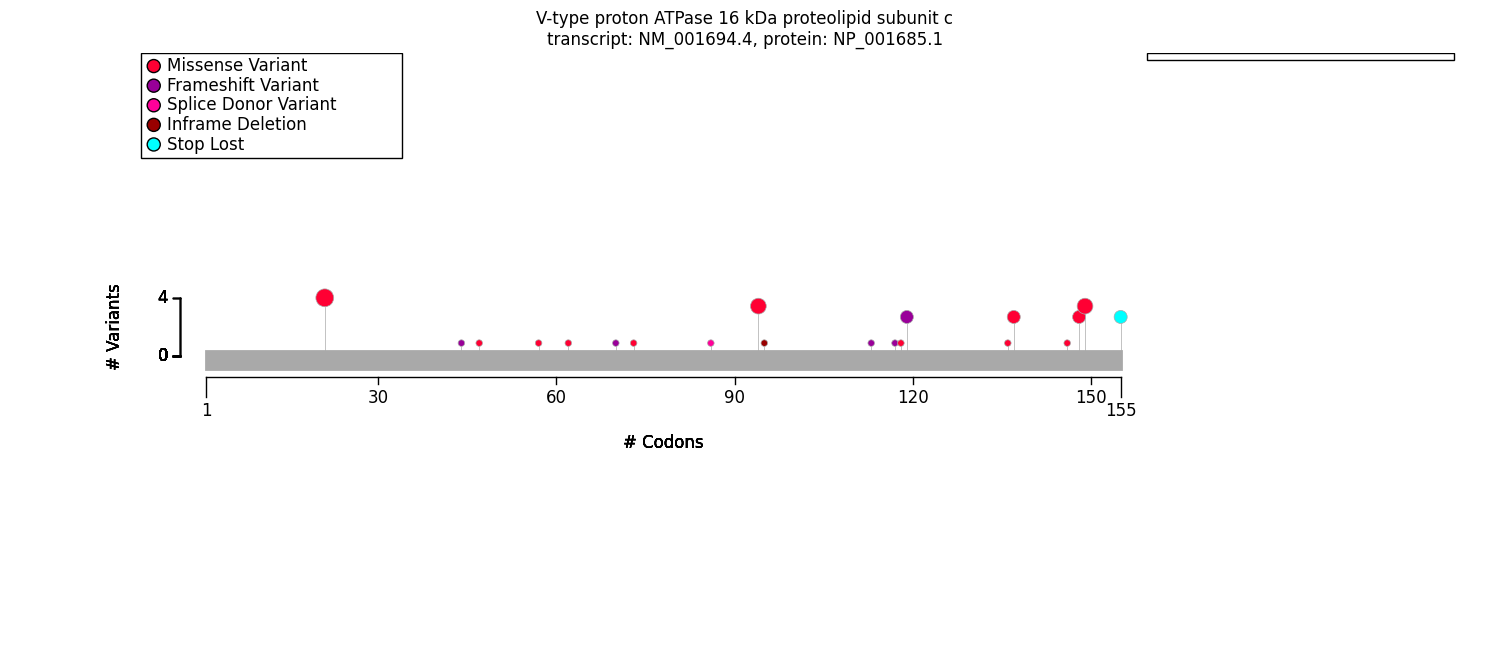

In [ ]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


ATP6V0C_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ATP6V0C_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(0,100), tx_id=mane_tx_id)
n_term_predicate = monoallelic_predicate(a_predicate=n_term, 
                                         b_predicate=~ n_term, 
                                         a_label="1-100", 
                                         b_label="100+")

In [8]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=n_term_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,62
HMF03,Skipping term because of a child term with the same individual counts,2
HMF08,Skipping general term,56
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,129


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                        1-100           100+  \
                                                    Count Percent  Count   
Intellectual disability, mild [HP:0001256]           0/11      0%   4/10   
Febrile seizure (within the age range of 3 mont...   8/15     53%   4/16   
Myoclonic seizure [HP:0032794]                       6/15     40%   2/15   
Global developmental delay [HP:0001263]              8/14     57%  13/16   
Absent speech [HP:0001344]                            3/7     43%   1/11   
Intellectual disability, severe [HP:0010864]          3/7     43%    1/9   
EEG abnormality [HP:0002353]                         6/10     60%   9/11   
Hypotonia [HP:0001252]                                3/7     43%   3/11   
Seizure [HP:0001250]                                13/13    100%  14/14   
Motor seizure [HP:0020219]                            7/7    100%    7/7   
Bilateral tonic-clonic seizure [HP:0002069]           7/7    100%  12/12   
Neurodevelopmental delay [HP:0012758]                 8/8    100%  13/13   
Neurodevelopmental abnormality [HP:0012759]         10/10    100%  14/14   
Delayed speech and language development [HP:000...    5/5    100%  11/11   
Abnormal communication [HP:0034434]                   5/5    100%  11/11   
Intellectual disability [HP:0001249]                  6/6    100%  11/11   
Morphological central nervous system abnormalit...    5/5    100%    8/8   
Abnormality of central nervous system electroph...    6/6    100%    9/9   
Motor delay [HP:0001270]                              3/3    100%  11/12   
Autistic behavior [HP:0000729]                        4/7     57%   6/10   

Allele group                                                                   \
                                                   Percent Corrected p values   
Intellectual disability, mild [HP:0001256]             40%           0.701754   
Febrile seizure (within the age range of 3 mont...     25%           0.871795   
Myoclonic seizure [HP:0032794]                         13%           0.871795   
Global developmental delay [HP:0001263]                81%           0.871795   
Absent speech [HP:0001344]                              9%           0.871795   
Intellectual disability, severe [HP:0010864]           11%           0.871795   
EEG abnormality [HP:0002353]                           82%           1.000000   
Hypotonia [HP:0001252]                                 27%           1.000000   
Seizure [HP:0001250]                                  100%           1.000000   
Motor seizure [HP:0020219]                            100%           1.000000   
Bilateral tonic-clonic seizure [HP:0002069]           100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormality of central nervous system electroph...    100%           1.000000   
Motor delay [HP:0001270]                               92%           1.000000   
Autistic behavior [HP:0000729]                         60%           1.000000   

Allele group                                                  
                                                    p values  
Intellectual disability, mild [HP:0001256]          0.035088  
Febrile seizure (within the age range of 3 mont...  0.148884  
Myoclonic seizure [HP:0032794]                      0.214759  
Global developmental delay [HP:0001263]             0.235982  
Absent speech [HP:0001344]                          0.245098  
Intellectual disability, severe [HP:0010864]        0.261538  
EEG abnormality [HP:0002353]            

In [10]:
from gpsea.model import VariantEffect
missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(a_predicate=missense,
                                           b_predicate=~missense,
                                           a_label="missense",
                                           b_label="other"
                                           )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Developmental regression [HP:0002376]                  0/11      0%    3/4   
Global developmental delay [HP:0001263]               16/21     76%    5/9   
Febrile seizure (within the age range of 3 mont...     7/21     33%   5/10   
Hypotonia [HP:0001252]                                 6/15     40%    0/3   
EEG abnormality [HP:0002353]                          12/16     75%    3/5   
Seizure [HP:0001250]                                  17/17    100%  10/10   
Motor seizure [HP:0020219]                              8/8    100%    6/6   
Bilateral tonic-clonic seizure [HP:0002069]           11/11    100%    8/8   
Neurodevelopmental delay [HP:0012758]                 16/16    100%    5/5   
Neurodevelopmental abnormality [HP:0012759]           17/17    100%    7/7   
Delayed speech and language development [HP:000...    13/13    100%    3/3   
Abnormal communication [HP:0034434]                   13/13    100%    3/3   
Intellectual disability [HP:0001249]                  11/11    100%    6/6   
Morphological central nervous system abnormalit...    11/11    100%    2/2   
Abnormality of central nervous system electroph...    12/12    100%    3/3   
Motor delay [HP:0001270]                              11/12     92%    3/3   
Autistic behavior [HP:0000729]                         8/14     57%    2/3   

Allele group                                                                   \
                                                   Percent Corrected p values   
Developmental regression [HP:0002376]                  75%           0.149451   
Global developmental delay [HP:0001263]                56%           1.000000   
Febrile seizure (within the age range of 3 mont...     50%           1.000000   
Hypotonia [HP:0001252]                                  0%           1.000000   
EEG abnormality [HP:0002353]                           60%           1.000000   
Seizure [HP:0001250]                                  100%           1.000000   
Motor seizure [HP:0020219]                            100%           1.000000   
Bilateral tonic-clonic seizure [HP:0002069]           100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormality of central nervous system electroph...    100%           1.000000   
Motor delay [HP:0001270]                              100%           1.000000   
Autistic behavior [HP:0000729]                         67%           1.000000   

Allele group                                                  
                                                    p values  
Developmental regression [HP:0002376]               0.008791  
Global developmental delay [HP:0001263]             0.388819  
Febrile seizure (within the age range of 3 mont...  0.447249  
Hypotonia [HP:0001252]                              0.514706  
EEG abnormality [HP:0002353]                        0.597523  
Seizure [HP:0001250]                                1.000000  
Motor seizure [HP:0020219]                          1.000000  
Bilateral tonic-clonic seizure [HP:0002069]         1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Delayed speech and language development [HP:000...  1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Intellectual disability [HP:0001249]                1.000000  
Morphological central nervous sy